In [36]:
"""
in this notebook, we recall the already-trained ANN from Casey et. al. for smoking detection. 300 input neurons, 10 hln, 1 output neuron. The weights are in ./casey_network. 

We obtained the weights from a bitbucket revision
1. Has shape (300,10,1)
-minMaxNorm
-weighted sum of inputs and weights plus bias
-tansigmoid
-weighted sum of hidden output and output weights plus bias
-log sigmoid
2. Weights and biases found here https://bitbucket.org/hvalafar/smokerapp-ver.-1.02/src/pill_taking_app_02/wear/src/main/assets/
3. They are "xyz_IW_b" and "xyz_LW_b" and "xyz_ranges" from 2018-11-19.
Proof that they were also using these files in https://bitbucket.org/hvalafar/smokerapp-ver.-1.02/src/pill_taking_app_02/wear/src/main/java/com/valafarlab/apps/MedicationStudy/Estimator.java
lines 217-219

We retrain the same architecture with pytorch.

We don't have the train-test split from Casey, but we have the entire dataset. We perform a train-test split 50/50 and save the files, as well as use random state 0 for reproducibility. We evaluate both the old model and the retrained model on both the holdout set and the entire dataset.

Considering we don't know what samples were train and holdout for the old model. We can expect that some proportion of the samples in our holdout set were training and some proportion were validation. If Casey used a split of 80/20, then we should expect the same proportion by random sampling theorem *inside* of our holdout set.
"""

import torch
from torch import nn
import pandas as pd
import numpy as np
# dataset generation
# X = pd.read_csv(f'smoking_data/smoking_input.csv',header=None)
# y = pd.read_csv(f'smoking_data/smoking_targets.csv',header=None)
# X = X.fillna(value=0.0)
# X.to_csv('X.csv',index=False)
# y.to_csv('y.csv',index=False)
# from sklearn.model_selection import train_test_split
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.5,shuffle=True,random_state=0)
# X_train.to_csv('X_train.csv',index=False)
# X_test.to_csv('X_test.csv',index=False)
# y_train.to_csv('y_train.csv',index=False)
# y_test.to_csv('y_test.csv',index=False)
# X = torch.from_numpy(X.to_numpy()).float()
# y = torch.from_numpy(y.to_numpy()).reshape(-1,1).float()
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.5,shuffle=True,random_state=0,stratify=True)
# torch.save((X,y),'smoking_data/all.pt')
# torch.save((X_train,y_train),'smoking_data/train.pt')
# torch.save((X_test,y_test),'smoking_data/test.pt')

In [18]:
class MLP(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.d1 = nn.Linear(300,10)
        self.d2 = nn.Linear(10,1)
    def forward(self,x):
        x = self.d1(x)
        x = nn.functional.relu(x)
        x = self.d2(x)
        return x
model = MLP()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())
model.to(device='cuda')

MLP(
  (d1): Linear(in_features=300, out_features=10, bias=True)
  (d2): Linear(in_features=10, out_features=1, bias=True)
)

In [19]:
X_train,y_train = torch.load('smoking_data/train.pt')
X_test,y_test = torch.load('smoking_data/test.pt')
X_train,X_test,y_train,y_test = X_train.cuda(),X_test.cuda(),y_train.cuda(),y_test.cuda()

In [20]:
losses = []
test_losses = []
for epoch in range(1000):
    logits = model(X_train)
    optimizer.zero_grad()
    loss = loss_fn(logits,y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    logits = model(X_test)
    loss = loss_fn(logits,y_test)
    test_losses.append(loss.item())

Text(0, 0.5, 'loss')

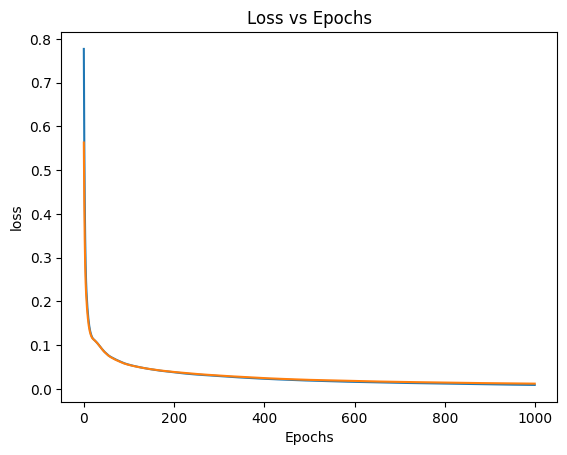

In [21]:
#plotting the loss
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(test_losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')

In [22]:
torch.save(model.state_dict(),'retrained_model.pt')

In [23]:
## evaluate both models
from pandas import read_csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


ranges = read_csv('casey_network/range',header=None).to_numpy()
iW = read_csv('casey_network/input',header=None).to_numpy()
hW = read_csv('casey_network/hidden',header=None).to_numpy()
def minMaxNorm(X):
    output = []
    for i,x in enumerate(X):
        output.append((2*((x-ranges[i][0])/(ranges[i][1]-ranges[i][0])))-1)
    return output
def tanSigmoid(X):
    output = []
    for x in X:
        output.append((2/(1+np.exp(-2*x)))-1)
    return output
def logSigmoid(x):
    return (1/(1+np.exp(-1*x)))
def forward(X):
    a = [1]+minMaxNorm(X)
    b = [1] + tanSigmoid(iW @ a)
    c = hW @ b
    d = logSigmoid(c[0])
    return d

In [24]:
# evaluate both on holdout
## disclaimer, we don't know what was training and what was holdout for orgiinal model, so we assume the current holdout contains approximately 80% training and 20% holdout of the original, by random chance

0.9971031692010633


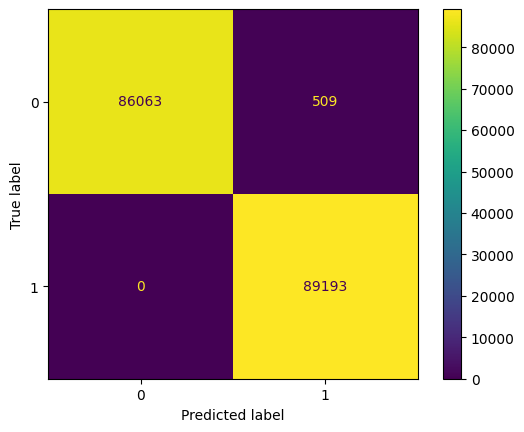

In [25]:
# retrained holdout
model = MLP().to(device='cuda')
model.load_state_dict(torch.load('retrained_model.pt'))
logits = model(X_test)
y_pred = nn.Sigmoid()(logits).round()
y_pred = y_pred.detach()
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
y_test_cpu = y_test.cpu()
y_pred_cpu = y_pred.cpu()

cm = ConfusionMatrixDisplay(confusion_matrix(y_test_cpu,y_pred_cpu))
cm.plot()
print(f1_score(y_pred=y_pred_cpu,y_true=y_test_cpu,average='macro'))

In [26]:
# casey holdout
X_test = pd.read_csv('smoking_data/X_test.csv')

In [28]:
y_pred_casey = []
from tqdm import tqdm
for row in tqdm(X_test.iloc):
    y_pred_casey.append(forward(row))

175765it [00:43, 4021.48it/s]


0.9971657789254147


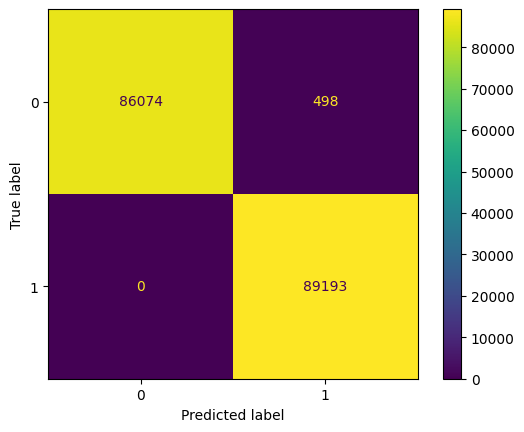

In [33]:
y_pred_casey_round = np.array(y_pred_casey).round()

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
y_test = pd.read_csv('smoking_data/y_test.csv')
cm = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred_casey_round))
cm.plot()
print(f1_score(y_pred=y_pred_casey_round,y_true=y_test,average='macro'))

In [34]:
X,y = torch.load('smoking_data/all.pt')

0.9974735291279817


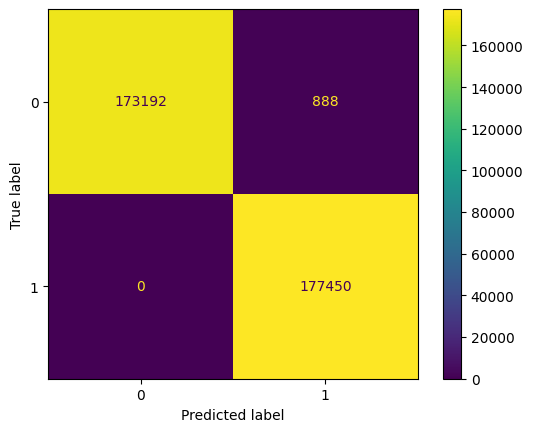

In [35]:
logits = model(X.cuda())
y_pred = nn.Sigmoid()(logits).round()
y_pred = y_pred.detach()
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
y_test_cpu = y
y_pred_cpu = y_pred.cpu()

cm = ConfusionMatrixDisplay(confusion_matrix(y_test_cpu,y_pred_cpu))
cm.plot()
print(f1_score(y_pred=y_pred_cpu,y_true=y_test_cpu,average='macro'))


351530it [01:27, 4037.79it/s]


0.9971605435878216


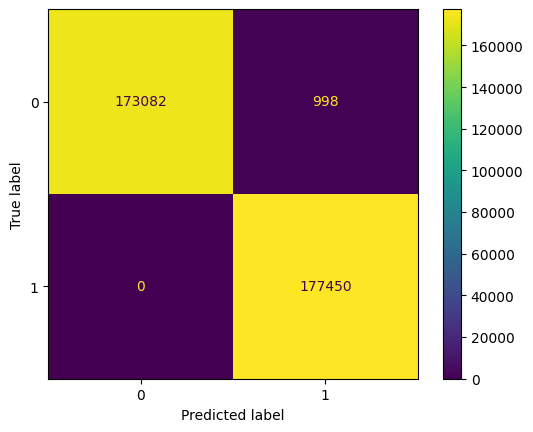

In [37]:
X = pd.read_csv('smoking_data/X.csv')
y = pd.read_csv('smoking_data/y.csv')
y_pred_casey = []
from tqdm import tqdm
for row in tqdm(X.iloc):
    y_pred_casey.append(forward(row))
y_pred_casey_round = np.array(y_pred_casey).round()

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
cm = ConfusionMatrixDisplay(confusion_matrix(y,y_pred_casey_round))
cm.plot()
print(f1_score(y_pred=y_pred_casey_round,y_true=y,average='macro'))